In [1]:
# Pkg used
using SparseArrays
using LinearAlgebra
using Arpack
using BenchmarkTools
using DelimitedFiles
using PyPlot

This is the full ED code for Kitaev-Heisernberg model on $2 \times 2 \times 3$ Kagome lattice, in which the periodic boundary condition is used.

\section{Kagome Lattice}

Kagome lattice is equvalent to replacing each site of a triangle lattice by a triangle. Therefore, it has three unequivalent sites in an unit cell. Here, we lable each atom as $(r,c,atom)$, where $(r,c)$ labels the position of an unit cell in the lattice, and $atom$ labels the a specific atom in the unit cell.

<img src = "Kagome-223.png" width = 200>

Note that we deliberately label the three atoms and three bonds like above so that there are only $k$-bond between $i,j$-atoms,where $i,j,k =1,2,3$ and $i \neq j \neq k$. This could simplify the code.

Set $\vec{n}_1 = (1,0), \vec{n}_2 = (\frac{1}{2},\frac{\sqrt{3}}{2})$, then the relative corredinates of each atom are: $\vec{r}_A = (1,\frac{\sqrt{3}}{6}),\vec{r}_B = (\frac{3}{4},\frac{5 \sqrt{3}}{12}),\vec{r}_C = (\frac{5}{4},\frac{5 \sqrt{3}}{12})$.

According to the lattice in paper: arXiv:1808.03127v1, we have: $\vec{n}_1 = (\frac{1}{2},\frac{\sqrt{3}}{2}), \vec{n}_2 = (-\frac{1}{2},\frac{\sqrt{3}}{2})$, then the relative corredinates of each atom are: $\vec{r}_A = (\frac{1}{4},\frac{\sqrt{3}}{4}),\vec{r}_B = (-\frac{1}{4},-\frac{\sqrt{3}}{4}),\vec{r}_C = (0,\frac{\sqrt{3}}{2})$.

In [2]:
struct Lattice{T <: Integer}
    # Lattice size set up
    N1::T
    N2::T
    end;

struct Position{T <: Integer}
    # position of an atom in the lattice
    row::T
    col::T
    atom::T
    end;

dimension(la::Lattice) = 2^(la.N1 * la.N2 * 3)
sitenum(la::Lattice) = la.N1 * la.N2 * 3

function index(pos::Position, incell::Int, which::Int, la::Lattice)
    #= Calculate the index of the atoms in the (r,c) unit cell.
       c, l start from 0.
       A-sublattice atom = 0; B-subkattice: atom = 1; C-subkattice: atom = 2.
       incell = 0,1 corresponds atoms out or inside of the unitcell
       which = 0, 1, 2, 3 corresponds to the original atom and 
        the one linked to it via x,y,z bonds =#
    sgn = 0
    if which == pos.atom + 1
        return(println("ERROR: No such bond!"))
    elseif which == 0
        if incell == 1
            a = pos.atom
            c = pos.col % la.N1
            r = pos.row % la.N2
        elseif incell == 0
            return println("ERROR: directions should be 1,2,3.")
        end
    elseif which != pos.atom + 1
        a = 5 - (pos.atom + 1) - which
        if incell == 1
            c = pos.col % la.N1
            r = pos.row % la.N2
        elseif incell == 0
            if which == 1
                sgn = pos.atom - a
                c = (pos.col + sgn)% la.N1
                r = pos.row % la.N2
            elseif which == 2
                sgn = pos.atom + 1 - which
                c = pos.col% la.N1
                r = (pos.row + sgn)% la.N2
            elseif which == 3
                sgn = pos.atom - a
                c = (pos.col + sgn)% la.N1
                r = (pos.row - sgn)% la.N2
            end
        end
    end
   
    c < 0 ? c += la.N1 : c += 0
    r < 0 ? r += la.N2 : r += 0
    
    #println(r, c, a)
    n = r * la.N1 + c
    return 3 * n + 1 + a
    end;

function findposition(ind::Int, la::Lattice)
    #= find the position of ind in the lattice
       ind starts from 1 =#
    atom = (ind -1)%3 
    n = div((ind -1 -atom),3)
    r, c = divrem(n, la.N1)
    return Position(r, c, atom)
    end;

function abs_coo(ind::Int, la::Lattice)
    r = zeros(3,2)
    
    #n1 = [1.,0.]; n2 = [1/2, sqrt(3)/2]
    #r[1,:] = [1., sqrt(3)/5]
    #r[2,:] = [3/4, 5*sqrt(3)/12]
    #r[3,:] = [5/4, 5*sqrt(3)/12]
    
    #n1 = [1/2,sqrt(3)/2]; n2 = [1/2, -sqrt(3)/2]
    #r[1,:] = [1/4, 7*sqrt(3)/12]
    #r[2,:] = [-1/4, -7*sqrt(3)/12]
    #r[3,:] = [0, 5*sqrt(3)/6]
    
    n1 = [1/2,sqrt(3)/2]; n2 = [1/2, -sqrt(3)/2]
    r[1,:] = [1/4, sqrt(3)/4]
    r[2,:] = [-1/4, sqrt(3)/4]
    r[3,:] = [0, sqrt(3)/2]
    
    pos = findposition(ind,la)
    coo = zeros(2)
    coo += pos.row * n2 + pos.col * n1
    coo += r[pos.atom+1, :]
    return coo
    end;

\section{Hamiltonian}

Here we consider spin-1/2 Kitaev-Heisenberg model:

\begin{equation}
    H = \sum_{<i,j>_\alpha} K S_i^\alpha S_j^\alpha + \sum_{<i,j>,\alpha} J S_i^\alpha S_j^\alpha
\end{equation}

where $\alpha = x,y,z$. We introduce parametrization $(J,K) = (I \cos \theta, I \sin \theta)$, where $I$ is the energy unit. We can write the $S_i^\alpha S_j^\alpha$ as:

\begin{align}
      S_i^x S_j^x &= \frac{1}{4} ( S_i^+ S_j^- + S_i^- S_j^+ + S_i^+ S_j^+            + S_i^- S_j^-)\\
      S_i^y S_j^y &= \frac{1}{4} ( S_i^+ S_j^- + S_i^- S_j^+ - S_i^+ S_j^+            - S_i^- S_j^-)\\
      S_i^z S_j^z &= S_i^z S_j^z \\
\end{align}

where $S_i^\pm = S_i^x \pm i S_i^y$.

\subsection{Make the Hamiltonian by iterating over all basis states}

In [3]:
"""Tool Functions"""
function bits(i::Integer, num::Integer)
    # Chenck the i-th element of the binary representation of a dicimal number
    # the bits count from right to left
    mask = 2^(i - 1)
    if num & mask == mask
        return 1
    else
        return 0
    end
    end;

function flip(i::Int, j::Int, tag::Int)
    #=Flip the spin on i,j site.
    Inputs: tag: tag of a state
            i,j: position of spins that are flipped
    Output: The tag of new state, type: int =#
    mask = 2^(i-1) + 2^(j-1)
    return xor(tag, mask)
    end;

function append_data(j::Int, colptr::Int, count::Int, row::Array{Int,1})
    point = colptr - 1
    for pos = colptr: count
        point += 1
        if row[pos] == j
            return pos, count
            break
        end
    end
            
    if point == count
        return count, count+1
    end
    end;

"""Generate Hamiltonian"""
function apply_Kitaev(ind::Int, bond::Int, incell::Int, si::Int, K::Array{Float64,1}, la::Lattice)
    # apply the ind-th Kitaev term on bond to si state
    pos = findposition(ind, la)
    if bond != pos.atom + 1
        nind = index(pos, incell, bond, la)
        val = 0.0
        if bond == 1
            sf = flip(ind, nind, si)
            val = K[1] /4
        elseif bond == 2
            sf = flip(ind, nind, si)
            val = -K[2] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
        elseif bond == 3
            sf = si
            val = K[3] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
        end
    elseif bond == pos.atom + 1
        sf = si
        val = 0.0
    end
    return sf, val
    end;

function apply_J(ind::Int, bond::Int, incell::Int, isz::Int, si::Int,J::Array{Float64,1}, la::Lattice)
    # Nearest neighbor Heisenberg Hamiltonian
    pos = findposition(ind, la)
    if bond != pos.atom + 1
        nind = index(pos, incell, bond, la)
        val = 0.0
        if isz == 1
            sf = si
            val = J[3] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
        else
            sf = flip(ind, nind, si)
            val = J[1]/4 - J[2] * (bits(ind, si) - 0.5) * (bits(nind, si) - 0.5)
        end
    elseif bond == pos.atom + 1
        sf = si
        val = 0.0
    end
    return sf, val
    end;

function Kitaev(K::Array{Float64,1}, la::Lattice)
    dim = dimension(la)
    num = sitenum(la)
    max = dim * num * 4
    error = 1.e-8
    
    col, row, data = zeros(Int, dim+1), zeros(Int, max), zeros(max)
    colptr, count = 1, 1
    
    K = K/2
    
    for si = 0: (dim-1)
        col[si+1] = colptr
        for ind = 1:num, bond = 1:3, incell = 0:1
            sf, val = apply_Kitaev(ind, bond, incell, si, K, la)
            if abs(val) > error
                pos, count = append_data(sf + 1, colptr, count, row)
                row[pos] = sf + 1
                data[pos] += val
            end
        end
        colptr = count
    end
    col[dim + 1] = count
    H = SparseMatrixCSC(dim, dim, col, row[1:count-1], data[1:count-1])
    H = sparse(H')
    return (1/2)*(H + H')
end

function Heisenberg(J::Array{Float64,1}, la::Lattice)
    dim = dimension(la)
    num = sitenum(la)
    max = dim * num * 2
    error = 1.e-8
    
    col, row, data = zeros(Int, dim+1), zeros(Int, max), zeros(max)
    colptr, count = 1, 1
    
    J = J/2
    
    for si = 0: (dim - 1)
        col[si + 1] = colptr
        for ind = 1:num, bond = 1:3, isz = 0:1, incell = 0:1
            sf, val = apply_J(ind, bond, incell, isz, si, J, la)
            if abs(val) > error
                pos, count = append_data(sf + 1, colptr, count, row)
                row[pos] = sf + 1
                data[pos] += val
            end
        end
        colptr = count
    end
    col[dim + 1] = count
    H = SparseMatrixCSC(dim, dim, col, row[1:count-1], data[1:count-1])
    H = sparse(H')
    return (1/2)*(H + H')
    end

Heisenberg (generic function with 1 method)

\subsection{Make the Hamiltonian by direct product}

In [4]:
function eye(dim::Int)
    # make sparse identity matrix
    return sparse(Matrix{Float64}(I, dim, dim))
end

function KH_Hamiltonian(J::Array{Float64,1}, K::Array{Float64,1}, la::Lattice)
    sx = 0.5 * sparse([0 1;1 0])
    sy = 0.5 * 1im * sparse([0 -1;1 0])
    sz = 0.5 * sparse([1 0;0 -1])
    
    J = J/2; K = K/2
    num = sitenum(la)
    dim = dimension(la)
    H = spzeros(Float64, dim, dim)

    for ind = 1:num, bond = 1:3, incell = 0:1
        fac = zeros(3)
        pos = findposition(ind, la)
        if bond != pos.atom + 1
            fac[bond] = 1.0
            nind = index(pos, incell, bond, la)
            l = max(ind, nind); s = min(ind, nind)
            di = 2^(s-1); dm = 2^(l-s-1); df = 2^(num-l)
            H += (J[1] + fac[1] * K[1])* kron( eye(di), kron( sx, kron( eye(dm), kron(sx, eye(df)))))
            H += (J[2] + fac[2] * K[2])* kron( eye(di), kron( sy, kron( eye(dm), kron(sy, eye(df)))))
            H += (J[3] + fac[3] * K[3])* kron( eye(di), kron( sz, kron( eye(dm), kron(sz, eye(df)))))
        else
        end
    end
    return real(H)
    end

KH_Hamiltonian (generic function with 1 method)

\section{Specfic heat, Entropy and Static spin structure factor}

In this section, we calculate specfic heat $C(T)$, entropy $S(T)$ and the $z$-component of static spin structure factor(SSSF) $S_q^z$.

The partition function $Z(T)$ of the canonical ensemble at temperature $T$ is expressed as follows:
\begin{equation}
    Z(T) = {\rm Tr} e^{-\beta H}  
\end{equation}

If we have all eigen-states $\{ | \psi_i \rangle \}$ and eigen-energies $E_i$, then $Z(T)$ can be expressed as:

\begin{equation}
    Z(T) = \sum_{i=1}^{N_s} \langle \psi_i | e^{-\beta H} | \psi_i \rangle 
       = \sum_{i=1}^{N_s} e^{-\beta E_i}
\end{equation}

The energy $E(T)$, specific heat $C(T)$ and entropy $S(T)$ can be calculated using the following general functions:

\begin{equation}
    E(T) = - \frac{\partial}{\partial \beta} \ln Z(T) 
        = \frac{1}{Z(T）}\sum_{i=1}^{N_s} E_i e^{-\beta E_i}
\end{equation}

\begin{equation}
    C(T) = - \frac{\partial}{\partial T} E(T) 
        = \frac{1}{T^2 Z(T)} \sum_{i=1}^{N_s} |E_i|^2 e^{-\beta E_i} 
            - \frac{|E(T)|^2}{T^2}
\end{equation}

\begin{equation}
    S(T) = \frac{E(T)}{T} + \ln Z(T)
\end{equation}

The $z$-component of SSSF is:

\begin{align}
    & S_q^z  = \frac{1}{N} \sum_{j,k} e^{i {\bf q} \cdot ({\bf r}_j - {\bf r}_k)}
    S_{{\bf r}_j}^z S_{{\bf r}_k}^z \\
   & S_q^z (T) = <S_q^z>(T) = \frac{1}{Z(T)} {\rm Tr} (S_q^z e^{-\beta H})
       = \frac{1}{Z(T)} \sum_{i=1}^{N_s} \langle \psi_i | S_q^z | \psi_i \rangle e^{-\beta E_i} 
\end{align}



In [5]:
"""Thermaldynamic quanties"""

function partitian(T::Float64, eng::Array{Float64,1}) 
    num = length(eng)
    z = 0.0
    for i = 1 : num
        z += exp(-(eng[i]-eng[1])/T)
    end
    return z
    end;

function energy(T::Float64, eng::Array{Float64,1}) 
    num = length(eng)
    e = 0.0
    z = partitian(T, eng)
    for i = 1 : num
        e += (eng[i]-eng[1]) * exp(-(eng[i]-eng[1])/T)
    end
    e = e / z
    return e
    end;

function specific_heat(T::Float64, eng::Array{Float64,1}) 
    num = length(eng)
    c = 0.0
    for i = 1 : num
        c += (eng[i]-eng[1]) * (eng[i]-eng[1])  * exp(-(eng[i]-eng[1])/T)
    end
    c = c / ( T * T * partitian(T, eng))
    c -= (energy(T,eng) / T)^2
    return c
    end;

function entropy(T::Float64, E::Float64, Z::Float64) 
    s = energy(T,eng) / T + log( partitian(T, eng) )
    return s
    end;


In [6]:
"""Test GS energy of K-H model"""
Theta = [x for x in LinRange(-1,1,101)]
la = Lattice(1,2)
eng = zeros(101)
for i = 1:101
    θ= Theta[i]
    J = cospi(θ) * ones(3)
    K = sinpi(θ) * ones(3)
    Hk = Kitaev(K, la)
    Hh = Heisenberg(J, la)
    Htot = Hk + Hh
    e, x = eigs(Htot, which = :SR)
    #H1 = KH_Hamiltonian(J,K,la)
    #e, x = eigs(H1, which = :SR)
    eng[i] = e[1]/12
end
println("Finish!")

Finish!


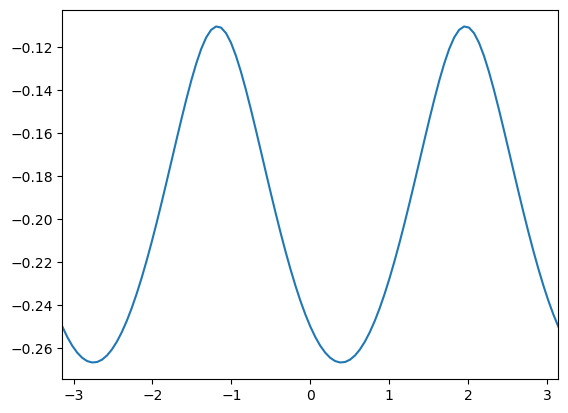

(-3.141592653589793, 3.141592653589793)

In [7]:
plot(Theta*pi, eng)
xlim(-pi,pi)

In [16]:
"""Test code"""
θ = 0.2
J = cospi(θ) * ones(3)
K = sinpi(θ) * ones(3)

println(J)
println(K)

la = Lattice(2,2)
N = sitenum(la)

Hk = Kitaev(K, la)
Hh = Heisenberg(J, la)
Htot = Hk + Hh

#Htot = KH_Hamiltonian(J,K,la)

#e, x = eigs(Htot, nev = 2^N -1, which = :SR)
Hdense  = Array(Htot)
e,x = eigen(Hdense)

println("Finish diagonalize K-H model!")

[0.809017, 0.809017, 0.809017]
[0.587785, 0.587785, 0.587785]
Finish diagonalize K-H model!


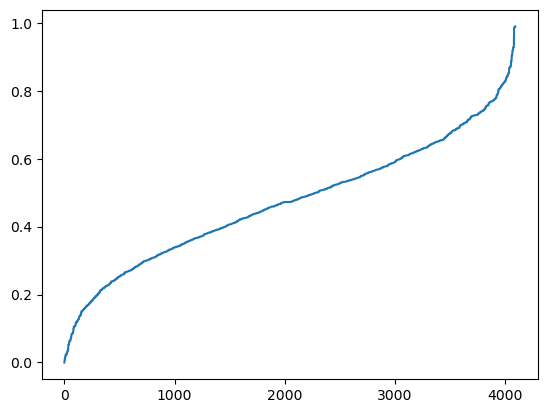

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000119F588>

In [17]:
"""Eigen-energy"""
dim = length(e)
delE = zeros(dim)
for i = 1:dim
    delE[i] = e[i] - e[1]
end

plot(delE/12)

In [18]:
""" Thermaldynamic quanties"""
step = 100
temp = [10^x for x in LinRange(-4,2,step)]
Z = zeros(step)
E = zeros(step)
C = zeros(step)
S = zeros(step)

#println(Z)
for i = 1: step
    t = temp[i]
    Z[i] += partitian(t, e)
    E[i] += energy(t,e)
    C[i] += specific_heat(t,e)
    S[i] += E[i]/t + log(Z[i])
end

println("Finish calculate Thermaldynamic quanties!")

Finish calculate Thermaldynamic quanties!


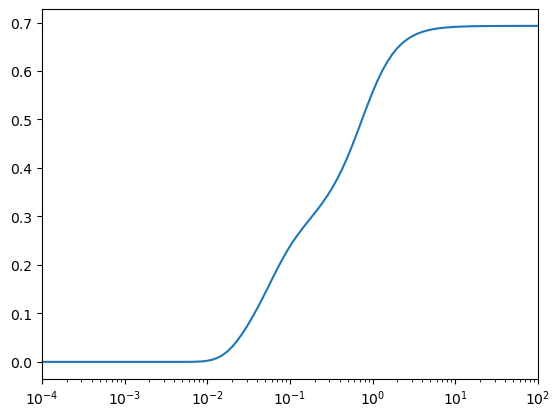

(0.00010000000000000005, 100)

In [19]:
#println(length(C))
#println(C)
semilogx(temp, S/N)
xlim(10^-4, 10^2)

In [31]:
"""SSSF"""
function Sz0(q::Array{Float64,1}, state::Array{Float64,1},la::Lattice)
    # <Sz> for a certain state
    error = 1.e-8
    num = sitenum(la); dim = dimension(la)
    
    sz = 0.0 + 0im
    for i=1:num,j=1:num
        ri = abs_coo(i,la); rj = abs_coo(j,la)
        phase = exp(1im * dot(q, ri - rj))
        for n = 1:dim
            sz += phase * state[n]' * state[n] * (bits(i,n-1)-0.5)*(bits(j,n-1)-0.5)
        end
    end
    if imag(sz) < error
        return(real(sz)/num)
    else
        return println("ERROR: large imaginary part!")
    end
end

function Szt(T::Float64, q::Array{Float64,1}, eng::Array{Float64,1}, basis::Array{Float64,2}, la::Lattice)
    z = partitian(T, eng)
    dim = dimension(la)
    st = 0.0
    for i= 1:dim
        st += Sz0(q, basis[:,i],la)  * exp(-(eng[i]-eng[1])/T)
    end
    return st/z
end

Szt (generic function with 1 method)

In [39]:
q = [2*pi,2*pi/sqrt(3)]

step = 100
temp = [10^x for x in LinRange(-4,2,step)]
sz = zeros(step)

for i = 1: step
    t = temp[i]
    sz[i] += Szt(t,q,e,x,la)
end
println("Finish calculate SSSF!")

Finish calculate SSSF!


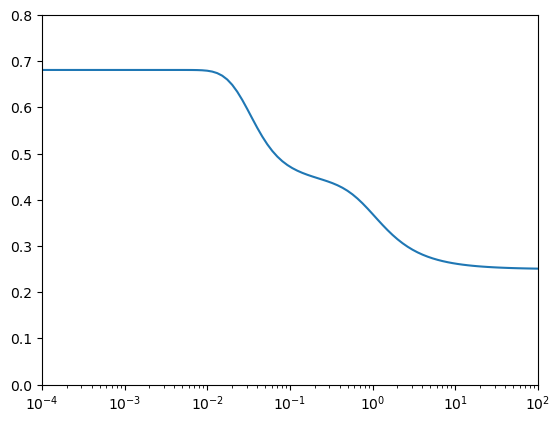

(0.0, 0.8)

In [42]:
semilogx(temp, sz)
xlim(10^-4, 10^2)
ylim(0,0.8)